##Sentiment Analysis Using Recurrent Neural Network

In [1]:
#Import req.libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from textblob import TextBlob

#Explore and load the dataset into a dataframe

In [2]:
data = pd.read_csv('/content/final_dataset.csv')

In [3]:
# Apply the sentiment analysis function to the 'preprocessed_text_tokenized' column and create a new 'polarity' column
data['polarity'] = data['preprocessed_text_tokenized'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [4]:
# Assign labels based on polarity
data['polarity_label'] = data['polarity'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1)

In [5]:
data['Sentiment'] = data['polarity'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative')

In [6]:
data.to_csv('/content/final_dataset_labeled.csv', index=False)

In [7]:
data.shape

(118298, 4)

In [8]:
data.head()

,preprocessed_text_tokenized,polarity,polarity_label,Sentiment
0,"['yet', 'benzema', 'co', 'dy', 'stink', 'saudi...",0.8,1,positive
1,"['talk', 'ronaldo', 'top', 'player', 'saudi', ...",0.5,1,positive
2,"['speak', 'reality', 'penaldo', 'delude', 'hat...",-0.4,-1,negative
3,"['obviously', 'know', 'ligue', 'one', 'player'...",0.0,0,neutral
4,"['forgotten', 'benzema', 'firminho', 'mahrez',...",0.0,0,neutral


In [9]:
del data['polarity']

In [10]:
del data['polarity_label']

In [11]:
data.shape

(118298, 2)

In [12]:
text = data['preprocessed_text_tokenized'].values
sentiment = data['Sentiment'].values

## Preprocessing on The dataset

In [13]:
# Tokenization & Padding the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
X_sequence = tokenizer.texts_to_sequences(text)
max_sequence_length = max([len(seq) for seq in X_sequence])
X_padded = pad_sequences(X_sequence, maxlen=max_sequence_length)

In [14]:
# Convert the Sentiment labels to Numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sentiment)
y_categorical = to_categorical(y, num_classes=3)  # Assuming 3 sentiment classes


## Train The model

In [15]:
# Build the RNN model
rnn = Sequential()
rnn.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=max_sequence_length))
rnn.add(SimpleRNN(64))  # Using a SimpleRNN layer
rnn.add(Dense(3, activation='softmax'))  # 3 output classes for sentiment analysis

In [16]:
#Compile the RNN model
rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [18]:
# Train the model
rnn.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
1479/1479 [==============================] - 1003s 677ms/step - loss: 0.8543 - accuracy: 0.6042 - val_loss: 0.4305 - val_accuracy: 0.8466
Epoch 2/15
1479/1479 [==============================] - 968s 655ms/step - loss: 0.2134 - accuracy: 0.9330 - val_loss: 0.1632 - val_accuracy: 0.9511
Epoch 3/15
1479/1479 [==============================] - 970s 656ms/step - loss: 0.1077 - accuracy: 0.9686 - val_loss: 0.1422 - val_accuracy: 0.9567
Epoch 4/15
1479/1479 [==============================] - 962s 650ms/step - loss: 0.1272 - accuracy: 0.9584 - val_loss: 0.2352 - val_accuracy: 0.9291
Epoch 5/15
1479/1479 [==============================] - 965s 652ms/step - loss: 0.0842 - accuracy: 0.9760 - val_loss: 0.1501 - val_accuracy: 0.9551
Epoch 6/15
1479/1479 [==============================] - 964s 652ms/step - loss: 0.0744 - accuracy: 0.9782 - val_loss: 0.1768 - val_accuracy: 0.9551
Epoch 7/15
1479/1479 [==============================] - 965s 652ms/step - loss: 0.0550 - accuracy: 0.9841 - val

## Evaluate the model

In [19]:
# Evaluate the model on the test set
y_pred = rnn.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

740/740 [==============================] - 52s 70ms/step


## Evaluation Metrics

Confusion Matrix:
[[ 3888    97   380]
 [   91  8003    98]
 [  307    67 10729]]


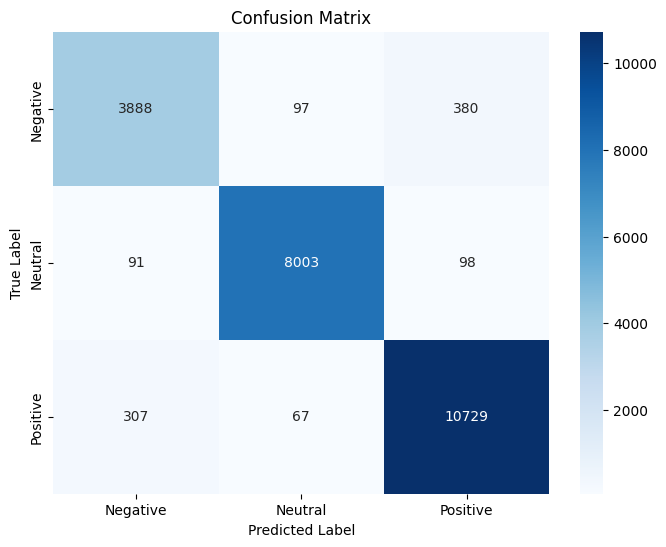

In [22]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues' ,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

ROC AUC Score: 0.9877


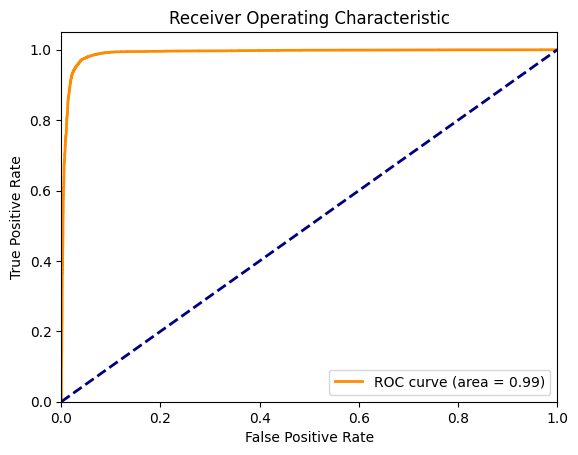

In [23]:
# ROC/AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the ROC/AUC for the model
auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')  # Assuming 'ovr' for multi-class
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4365
           1       0.98      0.98      0.98      8192
           2       0.96      0.97      0.96     11103

    accuracy                           0.96     23660
   macro avg       0.95      0.94      0.95     23660
weighted avg       0.96      0.96      0.96     23660



In [24]:
# Print the model accuracy
_, training_accuracy = rnn.evaluate(X_train, y_train)  # Evaluate the model on the training data and get the accuracy
_, test_accuracy = rnn.evaluate(X_test, y_test)  # Evaluate the model on the test data and get the accuracy
print(f'Training Set Accuracy: {training_accuracy * 100 :.4f}')
print(f'Test Set Accuracy: {test_accuracy * 100 :.4f}')

740/740 [==============================] - 53s 71ms/step - loss: 0.1883 - accuracy: 0.9560
Training Set Accuracy: 99.6756
Test Set Accuracy: 95.6044


In [26]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = rnn.evaluate(X_test, y_test)

print(f'Recurrent Neural Network model accuracy: {test_accuracy}')

740/740 [==============================] - 53s 72ms/step - loss: 0.1883 - accuracy: 0.9560
Recurrent Neural Network model accuracy: 0.9560439586639404


## Save the result

In [20]:
# Create a DataFrame with true and predicted labels
df = pd.DataFrame({
    'True Label': y_true_labels,
    'Predicted Label': y_pred_labels
    })

# Define the file path for saving the CSV file
file_path = 'RNN_Predict_result.csv.csv'

# Save the DataFrame to a new CSV file
df.to_csv(file_path, index=False)

print(f"The true labels and predicted labels have been saved to {file_path}.")


The true labels and predicted labels have been saved to RNN_Predict_result.csv.csv.


In [ ]:
df1 = pd.read_csv('/content/RNN_Predict_result.csv.csv')

# Count the occurrences of each sentiment label
sentiment_counts = df1['Predicted Label'].value_counts()

# Print the count of each sentiment label
print("Count of Neutral Sentiment :{}".format(sentiment_counts[1]))
print("Count of Positive Sentiment : {}".format(sentiment_counts[2]))
print("Count of Negative Sentiment : {}".format(sentiment_counts[0]))

In [ ]:
count_of_negative = 4286
count_of_neutral = 8167
count_of_positive = 11207

# Calculate the total count of all sentiments
total_count = count_of_neutral + count_of_positive + count_of_negative

# Calculate the percentage of each sentiment label
neutral_percentage = (count_of_neutral / total_count) * 100
positive_percentage = (count_of_positive / total_count) * 100
negative_percentage = (count_of_negative / total_count) * 100

# Print the percentage of each sentiment label
print("Neutral Sentiment: {:.2f}%".format(neutral_percentage))
print("Positive Sentiment: {:.2f}%".format(positive_percentage))
print("Negative Sentiment: {:.2f}%".format(negative_percentage))